# Multi-Agent Simulations of (Argumentative) Belief Dynamics with LMs

## General settings

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm
import logging
from IPython.display import display, HTML

from datetime import date
import os
import os.path
import matplotlib.pyplot as plt

from nltk import ngrams

import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [2]:
from beldynlm import *

In [13]:
import importlib
import beldynlm
importlib.reload(beldynlm)
torch.cuda.empty_cache()

In [3]:
!nvidia-smi

Thu Mar 11 17:53:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.56       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 29%   29C    P8    13W / 250W |      5MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     Off  | 00000000:5E:00.0 Off |                  Off |
| 34%   

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.__version__

'1.8.0+cu111'

### Topic 

In [6]:
topics = [
    {
        'id': 'compulsory_voting',
        'claims': {
            'connector': ' And therefore, all in all,',
            'pro': [' compulsory voting is a pretty good idea.', ' I am for compulsory voting.'],
            'con': [' compulsory voting is a really bad idea.', ' I am against compulsory voting.']
        },
        'intro': 'Let\'s discuss compulsory voting! Should citizens be free to abstain from voting? Or should voting be made compulsory?',
        'prompt': 'I agree with what my peers are saying here. In further support of the view they express, I\'d just add the following thought:\n',
        'initial_posts': [
            { 
                'type':'pro',
                'text':'Turnout in British election is distressingly low. Compulsory voting might fix this problem and increase the legitimacy of our government.'
            },
            { 
                'type':'pro',
                'text':'Low participation rates are doubly dangerous. They mean our politicians are not representative of the population as a whole.'
            },
            { 
                'type':'pro',
                'text':'Since the poor and disadvantaged are far less likely to vote than any other group, they can safely be ignored by mainstream politicians. The only way to break this cycle is mandatory voting.'
            },
            { 
                'type':'pro',
                'text':'We compel people to wear seatbelts and to serve on juries and we should not be afraid to do the same in the case of voting.'
            },
            { 
                'type':'pro',
                'text':'Liberal democracy relies on a balance of rights. Lack of participation puts our current political system in a crisis, which requires us to restrict some personal rights and to make voting mandatory.'
            },
            { 
                'type':'pro',
                'text':'We owe it to our ancestors, who fought for the establishement of democratic government, to exercise our right to vote. If people are so apathetic they will not do see freely, we must make it mandatory.'
            },
            {
                'type':'pro',
                'text':'Voting is compulsory in other countries, for instance in Australia. We should adopt the same system to secure greater democratic involvement.'
            },
            {
                'type':'pro',
                'text':'Proxy voting and postal voting will be available for those who cannot physically get to the polling station – voting by the Internet could also be arranged for.'
            },
            { 
                'type':'con',
                'text':'There are many reasons why people do not vote. Up to 10 per cent of the population is not on the electoral register at any one time.'
            },
            { 
                'type':'con',
                'text':'The alleged crisis of democracy does not allow for infringing an individual\'s liberty, including the liberty to abstain from voting.'
            },
            { 
                'type':'con',
                'text':'Compulsory voting would create political prisoners and hardly help the democratic process.'
            },
            { 
                'type':'con',
                'text':'Refraining from the democratic process is a democratic statement of disenchantment. Those who are disenchanted with politics in general have a right to register their dissatisfaction.'
            },
            { 
                'type':'con',
                'text':'Peoples right to abstain from voting should not be taken away by politicians who want to hide the fact of their upopularity and irrelevance in society.'
            },
            { 
                'type':'con',
                'text':'Just as the right to free speech is complemented by the right to silence, so the right to vote is balanced by the right of abstention.'
            },
            {
                'type':'con',
                'text':'Many people cannot get away from their work, or find someone to look after their children. And that\'s the reason why they don\'t vote.',
            },
            {
                'type':'con',
                'text':'Some people who don\'t vote cannot get physically to the polling booth. Others are simply not interested in politics.'
            },
            {
                'type':'con',
                'text':'There are many reasons why people don\'t vote. None of these motivations can be affected by forcing people to vote – those who cannot will continue not to, and those who are not interested will vote randomly.'
            },
            {
                'type':'pro',
                'text':'In the 1998 local elections, turnout averaged no more than 30 per cent, and in some areas under 20 per cent. Even in the 1997 general election, almost 30 per cent of the population did not vote.'
            }
            
        ]
    }
]

### Model and Tokenizer

In [7]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-large')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('gpt2-large')
model.to("cuda")

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2):

In [8]:
# test model

input_tensor = (tokenizer(["I am against mandatory voting!","I am against mandatory v!","All for it, too."],padding=True,return_tensors="pt")).to('cuda')

output = model(input_tensor['input_ids'], labels = input_tensor['input_ids'] )

labels = input_tensor['input_ids']
logits = output['logits']

for t in torch.split(labels,1):
    print(t)


tensor([[   40,   716,  1028, 13677,  6709,     0]], device='cuda:0')
tensor([[   40,   716,  1028, 13677,   410,     0]], device='cuda:0')
tensor([[3237,  329,  340,   11, 1165,   13]], device='cuda:0')


### Global parameters 

In [9]:
global_parameters = {
    'topic':'compulsory_voting',
    'n_agents':10,
    'max_t':8,
    'n_initial_posts':5, # number of initial posts, simulation starts at t = n_initial_posts
    'initial_neighb-peer_ratio':.5, # average ratio of neighbors that are initially considered peers
    'context_size':15, # max number of posts that are included in an agents perspective
    'relevance_deprecation':.9, # how much more likely (factor) is it the agents retains a post dating from (t-k-1) than one dating from (t-k)
    'self_confidence':1, # how much more likely (factor) is it the agents retains a post from her own than from a peer 
    'n_gram_prohibition':5, # drop generated sentences as soon as n-gram of this size is repeated 
    'perspective_expansion_method':'confirmation_bias', # 'random' or 'confirmation_bias'
    'conf_bias_exponent':5,
    'peer_selection_method':'all_neighbors', # 'all_neighbors' or 'bounded_confidence'
    'fwd_batch_size': 4
}

peer_selection_parameters = [
     {
         'id':'all_neighbors'
     },
     {
         'id':'bounded_confidence',
         'epsilon':0.002
     }
#    {
#        'id':'closed_rooms',
#        'by_roomsize': False, # Determine number of rooms by n_agents/agents_per_room
#        'n_rooms':2,
#        'agents_per_room':5
#    }
]



In [10]:
decoding_parameters = {
    'do_sample':True, 
    'num_beams':5,
    'temperature': 1, # 1.3,
    'top_p': 0.5, # 0.99, 
    'top_k':0,
     #'no_repeat_ngram_size':8,
    'repetition_penalty':1.2,
    'max_length':40,
    'bad_words_ids':[[LMUtilitiesMixIn.NEWLINE_TOKENID],[LMUtilitiesMixIn.ETC_TOKENID]]
}

# Listening Agents

## Initialization

In [11]:
topic = next(t for t in topics if t['id']==global_parameters['topic'])
topic['intro_tokens'] = tokenizer(topic['intro'])['input_ids']
topic['prompt_tokens'] = tokenizer(topic['prompt'])['input_ids']
topic['claim_tokens'] = {
    'connector': tokenizer(topic['claims']['connector'])['input_ids'],
    'pro':[tokenizer(t)['input_ids'] for t in topic['claims']['pro']], # list of token lists
    'con':[tokenizer(t)['input_ids'] for t in topic['claims']['con']] # list of token lists
}

conversation = Conversation(global_parameters=global_parameters,topic=topic)

agents = []
for i in range(global_parameters['n_agents']):
    agent = ListeningLMAgent(
        model=model, 
        tokenizer=tokenizer, 
        conversation=conversation, 
        neighbors=list(range(global_parameters['n_agents'])),
        peer_selection_args=next(args for args in peer_selection_parameters if args['id']==global_parameters['peer_selection_method']),
        perspective_expansion_method=global_parameters['perspective_expansion_method'],
        decoding_args=decoding_parameters,
        agent=i
    )
    agents.append(agent)

for agent in agents:
    agent.initialize()

## Loop

In [12]:
for t in tqdm(range(global_parameters['n_initial_posts'],global_parameters['max_t'])):
    for agent in agents:
        # Determine peers
        agent.update_peers(t)

        # Determine perspective
        agent.update_perspective(t)
        
        # Update opinion
        agent.update_opinion(t)

        

  0%|          | 0/3 [00:00<?, ?it/s]

<AxesSubplot:xlabel='step'>

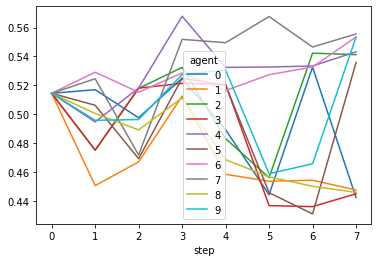

In [13]:
conversation.data.polarity.unstack().plot(legend=True)

<AxesSubplot:xlabel='step'>

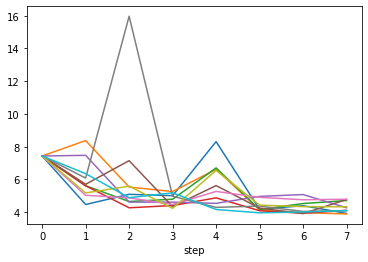

In [14]:
conversation.data.salience.unstack().plot(legend=False)

<AxesSubplot:xlabel='step'>

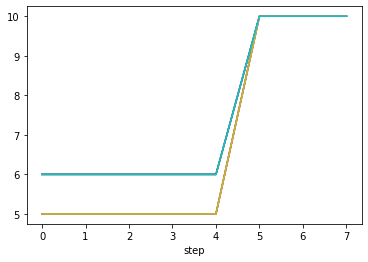

In [15]:
conversation.data.peers.apply(len).unstack().plot(legend=False)

<AxesSubplot:xlabel='step'>

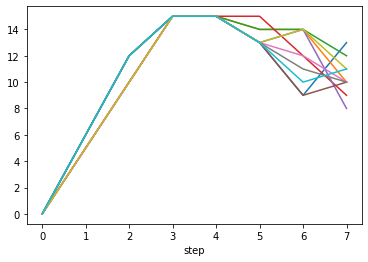

In [16]:
conversation.data.perspective.apply(len).unstack().plot(legend=False)

In [17]:
agents[0].peer_selection_args

{'id': 'all_neighbors'}

In [18]:
conversation.data.peers.unstack()

agent,0,1,2,3,4,5,6,7,8,9
step,,,,,,,,,,
0,"[8, 3, 6, 7, 2, 0]","[4, 6, 2, 7, 1]","[1, 0, 8, 5, 4, 2]","[1, 6, 3, 2, 8]","[9, 0, 5, 3, 4]","[4, 9, 2, 0, 7, 5]","[6, 2, 5, 0, 9]","[6, 2, 4, 9, 0, 7]","[4, 2, 8, 5, 0]","[3, 0, 1, 5, 4, 9]"
1,"[8, 3, 6, 7, 2, 0]","[4, 6, 2, 7, 1]","[1, 0, 8, 5, 4, 2]","[1, 6, 3, 2, 8]","[9, 0, 5, 3, 4]","[4, 9, 2, 0, 7, 5]","[6, 2, 5, 0, 9]","[6, 2, 4, 9, 0, 7]","[4, 2, 8, 5, 0]","[3, 0, 1, 5, 4, 9]"
2,"[8, 3, 6, 7, 2, 0]","[4, 6, 2, 7, 1]","[1, 0, 8, 5, 4, 2]","[1, 6, 3, 2, 8]","[9, 0, 5, 3, 4]","[4, 9, 2, 0, 7, 5]","[6, 2, 5, 0, 9]","[6, 2, 4, 9, 0, 7]","[4, 2, 8, 5, 0]","[3, 0, 1, 5, 4, 9]"
3,"[8, 3, 6, 7, 2, 0]","[4, 6, 2, 7, 1]","[1, 0, 8, 5, 4, 2]","[1, 6, 3, 2, 8]","[9, 0, 5, 3, 4]","[4, 9, 2, 0, 7, 5]","[6, 2, 5, 0, 9]","[6, 2, 4, 9, 0, 7]","[4, 2, 8, 5, 0]","[3, 0, 1, 5, 4, 9]"
4,"[8, 3, 6, 7, 2, 0]","[4, 6, 2, 7, 1]","[1, 0, 8, 5, 4, 2]","[1, 6, 3, 2, 8]","[9, 0, 5, 3, 4]","[4, 9, 2, 0, 7, 5]","[6, 2, 5, 0, 9]","[6, 2, 4, 9, 0, 7]","[4, 2, 8, 5, 0]","[3, 0, 1, 5, 4, 9]"
5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
6,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
7,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"


In [19]:
display_agents = [2,3,4,6,5]
#display_agents = [2,4,6,8,0]
def get_persp(i):
    ser = conversation.data.xs(i, level=1, drop_level=True)['perspective'].apply(lambda p: p)
    ser = ser.rename('agent '+str(i))
    return ser    
def get_posts(i): 
    ser = conversation.data.xs(i, level=1, drop_level=True)['post'].apply(lambda p: p['text'])
    ser = ser.rename('agent '+str(i))
    return ser
display(HTML(
    pd.concat([get_persp(i) for i in display_agents], axis=1).to_html()
))

,agent 2,agent 3,agent 4,agent 6,agent 5
step,,,,,
0,[],[],[],[],[]
1,"[(0, 1), (0, 0), (0, 8), (0, 5), (0, 4), (0, 2)]","[(0, 1), (0, 6), (0, 3), (0, 2), (0, 8)]","[(0, 9), (0, 0), (0, 5), (0, 3), (0, 4)]","[(0, 6), (0, 2), (0, 5), (0, 0), (0, 9)]","[(0, 4), (0, 9), (0, 2), (0, 0), (0, 7), (0, 5)]"
2,"[(0, 1), (0, 0), (0, 8), (0, 5), (0, 4), (0, 2), (1, 1), (1, 0), (1, 8), (1, 5), (1, 4), (1, 2)]","[(0, 1), (0, 6), (0, 3), (0, 2), (0, 8), (1, 1), (1, 6), (1, 3), (1, 2), (1, 8)]","[(0, 9), (0, 0), (0, 5), (0, 3), (0, 4), (1, 9), (1, 0), (1, 5), (1, 3), (1, 4)]","[(0, 6), (0, 2), (0, 5), (0, 0), (0, 9), (1, 6), (1, 2), (1, 5), (1, 0), (1, 9)]","[(0, 4), (0, 9), (0, 2), (0, 0), (0, 7), (0, 5), (1, 4), (1, 9), (1, 2), (1, 0), (1, 7), (1, 5)]"
3,"[(0, 8), (1, 0), (2, 8), (0, 1), (0, 4), (0, 5), (2, 4), (1, 5), (0, 2), (2, 0), (2, 1), (1, 8), (2, 2), (1, 2), (2, 5)]","[(0, 1), (0, 6), (0, 3), (0, 2), (0, 8), (1, 1), (1, 6), (1, 3), (1, 2), (1, 8), (2, 1), (2, 6), (2, 3), (2, 2), (2, 8)]","[(0, 9), (0, 0), (0, 5), (0, 3), (0, 4), (1, 9), (1, 0), (1, 5), (1, 3), (1, 4), (2, 9), (2, 0), (2, 5), (2, 3), (2, 4)]","[(0, 6), (0, 2), (0, 5), (0, 0), (0, 9), (1, 6), (1, 2), (1, 5), (1, 0), (1, 9), (2, 6), (2, 2), (2, 5), (2, 0), (2, 9)]","[(1, 7), (0, 0), (0, 5), (1, 4), (0, 2), (0, 9), (1, 0), (0, 4), (1, 5), (2, 9), (1, 2), (2, 7), (2, 5), (1, 9), (0, 7)]"
4,"[(2, 4), (0, 2), (1, 4), (2, 0), (1, 1), (0, 5), (1, 0), (2, 2), (3, 1), (1, 8), (0, 8), (2, 8), (1, 5), (3, 2), (0, 1)]","[(0, 8), (1, 6), (3, 3), (2, 1), (0, 1), (2, 2), (3, 6), (2, 3), (3, 1), (1, 8), (0, 2), (1, 2), (0, 3), (0, 6), (2, 8)]","[(3, 4), (2, 3), (3, 9), (0, 4), (3, 0), (0, 3), (1, 9), (1, 0), (0, 9), (3, 3), (2, 4), (1, 3), (2, 9), (0, 0), (2, 0)]","[(2, 5), (2, 9), (1, 0), (3, 0), (0, 5), (0, 9), (2, 0), (0, 6), (3, 6), (3, 2), (0, 0), (2, 6), (1, 9), (1, 2), (0, 2)]","[(3, 2), (2, 0), (3, 5), (2, 9), (3, 7), (1, 4), (0, 7), (2, 5), (1, 5), (0, 2), (2, 4), (0, 0), (0, 9), (0, 5), (3, 9)]"
5,"[(0, 1), (2, 4), (1, 5), (3, 1), (1, 1), (2, 0), (1, 4), (0, 2), (0, 5), (2, 2), (1, 0), (1, 6), (3, 2), (2, 8)]","[(0, 1), (1, 2), (2, 1), (3, 1), (3, 7), (1, 8), (0, 3), (0, 6), (2, 3), (3, 3), (3, 6), (2, 2), (1, 6), (0, 8), (2, 8)]","[(2, 4), (0, 4), (3, 4), (0, 0), (0, 3), (0, 9), (2, 0), (1, 4), (2, 3), (2, 9), (3, 3), (3, 9), (1, 9)]","[(1, 2), (2, 7), (0, 0), (3, 1), (0, 9), (2, 0), (3, 0), (0, 6), (2, 6), (3, 6), (1, 0), (2, 5), (1, 9)]","[(2, 4), (1, 2), (3, 7), (2, 0), (0, 9), (1, 4), (2, 3), (2, 9), (3, 9), (0, 5), (3, 2), (2, 5), (3, 5)]"
6,"[(0, 1), (2, 4), (1, 5), (1, 1), (0, 3), (2, 0), (1, 4), (0, 2), (0, 5), (2, 2), (1, 0), (1, 6), (3, 2), (0, 8)]","[(1, 2), (2, 2), (2, 1), (3, 7), (0, 3), (0, 6), (2, 3), (3, 6), (1, 6), (0, 8), (2, 5), (2, 8)]","[(0, 7), (2, 4), (1, 2), (0, 4), (3, 4), (0, 0), (0, 3), (0, 9), (2, 0), (1, 4), (2, 3), (2, 9), (3, 3), (1, 9)]","[(0, 4), (2, 7), (0, 0), (3, 1), (0, 9), (3, 0), (0, 6), (1, 7), (2, 6), (3, 6), (2, 5), (1, 9)]","[(2, 4), (1, 2), (3, 7), (2, 0), (1, 4), (2, 3), (1, 6), (2, 5), (3, 5)]"
7,"[(0, 1), (2, 4), (1, 5), (1, 1), (0, 3), (1, 4), (0, 5), (1, 0), (1, 6), (3, 2), (2, 5), (0, 8)]","[(2, 4), (2, 1), (3, 7), (0, 6), (2, 3), (2, 2), (0, 8), (2, 5), (2, 8)]","[(0, 7), (2, 4), (1, 2), (3, 7), (0, 3), (1, 6), (2, 5), (1, 9)]","[(2, 4), (2, 7), (3, 1), (3, 7), (3, 0), (0, 6), (1, 7), (2, 6), (3, 6), (2, 5)]","[(2, 4), (1, 2), (0, 0), (3, 7), (2, 0), (1, 4), (2, 3), (2, 6), (0, 8), (2, 5)]"


# Generating Agents

## Initialization

In [11]:
topic = next(t for t in topics if t['id']==global_parameters['topic'])
topic['intro_tokens'] = tokenizer(topic['intro'])['input_ids']
topic['prompt_tokens'] = tokenizer(topic['prompt'])['input_ids']
topic['claim_tokens'] = {
    'connector': tokenizer(topic['claims']['connector'])['input_ids'],
    'pro':[tokenizer(t)['input_ids'] for t in topic['claims']['pro']], # list of token lists
    'con':[tokenizer(t)['input_ids'] for t in topic['claims']['con']] # list of token lists
}

conversation = Conversation(global_parameters=global_parameters,topic=topic)

agents = []
for i in range(global_parameters['n_agents']):
    agent = GeneratingLMAgent(
        model=model, 
        tokenizer=tokenizer, 
        conversation=conversation, 
        neighbors=list(range(global_parameters['n_agents'])),
        peer_selection_args=next(args for args in peer_selection_parameters if args['id']==global_parameters['peer_selection_method']),
        perspective_expansion_method=global_parameters['perspective_expansion_method'],
        decoding_args=decoding_parameters,
        agent=i
    )
    agents.append(agent)

for agent in agents:
    agent.initialize(initial_steps=2)

agents[1].conversation.data.loc[1]


,post,peers,perspective,tokens,polarity,salience
agent,,,,,,
0,"{'type': 'con', 'text': 'Just as the right to ...","[9, 8, 3, 0, 4]","[(0, 9), (0, 8), (0, 3), (0, 0), (0, 4)]","[5703, 355, 262, 826, 284, 1479, 4046, 318, 12...",0.452132,4.05041
1,"{'type': 'con', 'text': 'Refraining from the d...","[5, 4, 6, 3, 7, 1]","[(0, 5), (0, 4), (0, 6), (0, 3), (0, 7), (0, 1)]","[8134, 24674, 422, 262, 10518, 1429, 318, 257,...",0.549509,8.372728
2,"{'type': 'con', 'text': 'There are many reason...","[4, 0, 8, 9, 7, 2]","[(0, 4), (0, 0), (0, 8), (0, 9), (0, 7), (0, 2)]","[1858, 389, 867, 3840, 1521, 661, 466, 407, 30...",0.434829,4.108567
3,"{'type': 'pro', 'text': 'Turnout in British el...","[2, 9, 0, 7, 5, 3]","[(0, 2), (0, 9), (0, 0), (0, 7), (0, 5), (0, 3)]","[17278, 448, 287, 3517, 3071, 318, 17087, 4420...",0.43423,4.637991
4,"{'type': 'con', 'text': 'Just as the right to ...","[4, 9, 2, 6, 5]","[(0, 4), (0, 9), (0, 2), (0, 6), (0, 5)]","[5703, 355, 262, 826, 284, 1479, 4046, 318, 12...",0.424165,4.402148
5,"{'type': 'pro', 'text': 'Liberal democracy rel...","[5, 6, 4, 1, 9]","[(0, 5), (0, 6), (0, 4), (0, 1), (0, 9)]","[46650, 7996, 16507, 319, 257, 5236, 286, 2489...",0.522237,6.57251
6,"{'type': 'con', 'text': 'Refraining from the d...","[7, 8, 9, 6, 2]","[(0, 7), (0, 8), (0, 9), (0, 6), (0, 2)]","[8134, 24674, 422, 262, 10518, 1429, 318, 257,...",0.446502,4.33282
7,"{'type': 'con', 'text': 'Refraining from the d...","[1, 9, 2, 5, 8, 7]","[(0, 1), (0, 9), (0, 2), (0, 5), (0, 8), (0, 7)]","[8134, 24674, 422, 262, 10518, 1429, 318, 257,...",0.454248,5.941696
8,"{'type': 'pro', 'text': 'In the 1998 local ele...","[3, 0, 6, 5, 9, 8]","[(0, 3), (0, 0), (0, 6), (0, 5), (0, 9), (0, 8)]","[818, 262, 7795, 1957, 7024, 11, 21666, 16449,...",0.47744,5.005406


## Loop

In [12]:
for t in tqdm(range(global_parameters['n_initial_posts'],global_parameters['max_t'])):
    for agent in agents:
        # Determine peers
        agent.update_peers(t)

        # Determine perspective
        agent.update_perspective(t)

        # Generate posts
        agent.make_contribution(t)
        
        # Update opinion
        agent.update_opinion(t)

        

  0%|          | 0/8 [00:00<?, ?it/s]

<AxesSubplot:xlabel='step'>

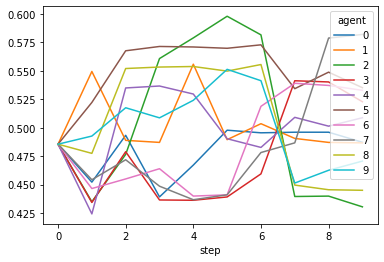

In [13]:
conversation.data.polarity.unstack().plot(legend=True)

<AxesSubplot:xlabel='step'>

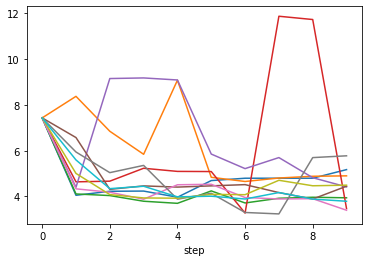

In [14]:
conversation.data.salience.unstack().plot(legend=False)

<AxesSubplot:xlabel='step'>

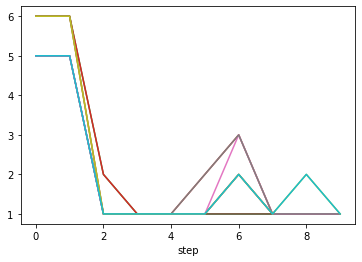

In [15]:
conversation.data.peers.apply(len).unstack().plot(legend=False)

<AxesSubplot:xlabel='step'>

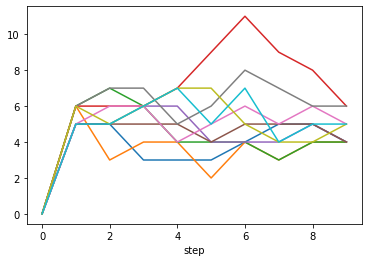

In [16]:
conversation.data.perspective.apply(len).unstack().plot(legend=False)

In [17]:
agents[0].peer_selection_args

{'id': 'bounded_confidence', 'epsilon': 0.002}

In [18]:
conversation.data.peers.unstack()

agent,0,1,2,3,4,5,6,7,8,9
step,,,,,,,,,,
0,"[9, 8, 3, 0, 4]","[5, 4, 6, 3, 7, 1]","[4, 0, 8, 9, 7, 2]","[2, 9, 0, 7, 5, 3]","[4, 9, 2, 6, 5]","[5, 6, 4, 1, 9]","[7, 8, 9, 6, 2]","[1, 9, 2, 5, 8, 7]","[3, 0, 6, 5, 9, 8]","[1, 9, 3, 4, 7]"
1,"[9, 8, 3, 0, 4]","[5, 4, 6, 3, 7, 1]","[4, 0, 8, 9, 7, 2]","[2, 9, 0, 7, 5, 3]","[4, 9, 2, 6, 5]","[5, 6, 4, 1, 9]","[7, 8, 9, 6, 2]","[1, 9, 2, 5, 8, 7]","[3, 0, 6, 5, 9, 8]","[1, 9, 3, 4, 7]"
2,[0],[1],"[2, 3]","[2, 3]",[4],[5],[6],[7],[8],[9]
3,[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]
4,[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]
5,[0],[1],[2],"[3, 7]",[4],[5],[6],"[3, 7]",[8],[9]
6,[0],"[1, 4]",[2],"[3, 6, 7]","[1, 4]",[5],"[3, 6, 7]","[3, 6, 7]","[8, 9]","[8, 9]"
7,[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]
8,[0],[1],[2],[3],[4],[5],[6],[7],"[8, 9]","[8, 9]"


In [19]:
display_agents = [3,4,6,5]
#display_agents = [2,4,6,8,0]
def get_posts(i): 
    ser = conversation.data.xs(i, level=1, drop_level=True)['post'].apply(lambda p: p['text'])
    ser = ser.rename('agent '+str(i))
    return ser
display(HTML(
    pd.concat([get_posts(i) for i in display_agents], axis=1).to_html()
))

,agent 3,agent 4,agent 6,agent 5
step,,,,
0,"Just as the right to free speech is complemented by the right to silence, so the right to vote is balanced by the right of abstention.","Voting is compulsory in other countries, for instance in Australia. We should adopt the same system to secure greater democratic involvement.","The alleged crisis of democracy does not allow for infringing an individual's liberty, including the liberty to abstain from voting.","In the 1998 local elections, turnout averaged no more than 30 per cent, and in some areas under 20 per cent. Even in the 1997 general election, almost 30 per cent of the population did not vote."
1,Turnout in British election is distressingly low. Compulsory voting might fix this problem and increase the legitimacy of our government.,"Just as the right to free speech is complemented by the right to silence, so the right to vote is balanced by the right of abstention.",Refraining from the democratic process is a democratic statement of disenchantment. Those who are disenchanted with politics in general have a right to register their dissatisfaction.,"Liberal democracy relies on a balance of rights. Lack of participation puts our current political system in a crisis, which requires us to restrict some personal rights and to make voting mandatory."
2,"If we are going to have compulsory voting, we should make it compulsory for everyone.","If there is a crisis of democracy, it is not because people are not voting. It is because people are not participating in the democratic process.","If you don't vote, you don't matter.",Compulsory voting would create political prisoners and hardly help the democratic process. It would only encourage people to vote against their own interests.
3,It would be interesting to know how many of those who do not vote in British elections actually turn out to vote in the next election.,It is not the responsibility of the state to make sure that every citizen participates in the democratic process. It is the responsibility of the citizen to participate in the democratic process.,"If you don't vote, you don't matter.",Compulsory voting would create political prisoners and hardly help the democratic process.
4,"If we are going to have compulsory voting, we should make it compulsory for everyone.","If there is a crisis of democracy, it is not because people are not voting. It is because people are not participating in the democratic process.","If you don't vote, you don't matter.","If you want to make voting compulsory, why don't you make it compulsory for everyone?"
5,"If we are going to have compulsory voting, we should make it compulsory for everyone.",The fact that there is a crisis of democracy is not because people are not voting. It is because people are not participating in the democratic process.,I am not a fan of compulsory voting. I don't think it is a good idea.,Compulsory voting would create political prisoners and hardly help the democratic process.
6,"If we are going to have compulsory voting, we should make it compulsory for everyone.","If we are going to make voting compulsory, why not make it compulsory for those who can't physically get to the polling station?","If we are going to have compulsory voting, let's make it compulsory for everyone.",Compulsory voting would create political prisoners and hardly help the democratic process.
7,"If we are going to have compulsory voting, let's make it compulsory for everyone.","If there is a crisis of democracy, it is not because people are not voting. It is because people are not participating in the democratic process.","If we are going to have compulsory voting, let's make it compulsory for everyone.",I agree with what my peers are saying here.
8,"If we are going to have compulsory voting, let's make it compulsory for everyone.","If there is a crisis of democracy, it is not because people are not voting. It is because people are not participating in the democratic process.","If you don't vote, y

In [418]:
from datetime import date
import os
import os.path
today = date.today().isoformat()
today
filename_root = "bd_results_"+today+"_"
result_files_today = [f for f in os.listdir('.') if f.startswith(filename_root)]
filename=filename_root+str(len(result_files_today)+1)+".csv"

conversation.data.to_csv(filename)

# DEPRECATED

## Define Dynamics

### Peer selection

In [465]:
peer_sel_param = next(p for p in peer_selection_parameters if p['id']==global_parameters['peer_selection_method'])

if peer_sel_param['id']=='closed_rooms':
    n_rooms = round(global_parameters['n_agents']/peer_sel_param['agents_per_room']) if peer_sel_param['by_roomsize'] else peer_sel_param['n_rooms']
    #assign each agent a room
    #room_assignments = random.choices(list(range(n_rooms)),k=global_parameters['n_agents']) # random
    room_assignments = [i%n_rooms for i in range(global_parameters['n_agents'])] # modulo
    #print(room_assignments)
    peers = [[j for j,r in enumerate(room_assignments) if r==room_assignments[i]] for i in range(global_parameters['n_agents'])]
    #print(peers)
    
    def peer_selection(df,t):
        return peers

### Context creation

In [466]:
def context_creation(df,t):
    c_max = global_parameters['context_size']
    delta = global_parameters['relevance_deprecation']
    context_old = df.loc[t-1]['context'] # start with context from previous step
    context_old = context_old.rename('old')
    context_new = df.loc[t]['peers'].apply(lambda peers: [[t-1,p] for p in peers])# all the new stuff the peers have been saying at t
    context_new = context_new.rename('new')
    
    def merge_and_drop(row):
        con = row.new + row.old
        if len(con)>global_parameters['context_size']:
            con_sampled = []
            for i in range(global_parameters['context_size']):
                weights = [(global_parameters['self_confidence'] if x[1]==row.agent else 1) * (delta**(t-x[0])) for x in con]
                #print(weights)
                retain = random.choices(con,k=1,weights=weights)[0]
                con.remove(retain)
                con_sampled.append(retain)
            con = con_sampled
        return con
    contexts = pd.concat([context_old,context_new,pd.Series(agents,name='agent')],axis=1).apply(merge_and_drop, axis=1)
    return contexts

### Generation of posts

## Initialization

In [17]:
topic = next(t for t in topics if t['id']==global_parameters['topic'])
topic['intro_tokens'] = tokenizer(topic['intro'])['input_ids']
topic['prompt_tokens'] = tokenizer(topic['prompt'])['input_ids']

We store all the results in hiarchically indexed dataframe.

In [57]:
Conversation(global_parameters,topic).data

post peers context tokens
step agent                          
0    0        0    []      []      0
     1        0    []      []      0
     2        0    []      []      0
     3        0    []      []      0
     4        0    []      []      0
...         ...   ...     ...    ...
49   5        0    []      []      0
     6        0    []      []      0
     7        0    []      []      0
     8        0    []      []      0
     9        0    []      []      0

[500 rows x 4 columns]

In [469]:
columns = ['post','peers','context','tokens']
steps = np.arange(global_parameters['max_t'])
agents = np.arange(global_parameters['n_agents'])
steps_agents = [
   steps,
   agents
]
index = pd.MultiIndex.from_product(steps_agents, names=["step", "agent"])
df = pd.DataFrame(np.zeros((global_parameters['max_t']*global_parameters['n_agents'], len(columns))), index=index, columns=columns)
df = df.astype(object)
df['context']=[[] for i in range(len(df))]
df['peers']=[[] for i in range(len(df))]

We initialize peer groups.

In [470]:
# initialize peers
for t in range(global_parameters['n_initial_posts']):
    df.loc[t]['peers']=peer_selection(df,t)

We initialize context.

In [471]:
for t in range(1,global_parameters['n_initial_posts']):
    df.loc[t]['context']=context_creation(df,t)

We initialize posts (from topic)

In [472]:
for t in range(global_parameters['n_initial_posts']):
    #new_series = pd.Series(
    #    random.choices(topic['initial_posts'],k=global_parameters['n_agents']),
    #    index = pd.RangeIndex(global_parameters['n_agents'], name='agent')
    #)
    # df.loc[t]['post'] = random.choices(topic['initial_posts'],k=global_parameters['n_agents']) # random
    # pro / con split in groups
    pros = [p for p in topic['initial_posts'] if p['type']=='pro']
    cons = [p for p in topic['initial_posts'] if p['type']=='con']
    df.loc[t]['post'] = df.loc[t]['peers'].apply(lambda peers: random.choice(pros) if (0 in peers) else random.choice(cons)) 
    df.loc[t]['tokens'] = df.loc[t]['post'].apply(lambda p: tokenizer(p['text'])['input_ids'])

In [473]:
df.loc[:2]

post  \
step agent                                                      
0    0      {'type': 'pro', 'text': 'Voting is compulsory ...   
     1      {'type': 'con', 'text': 'There are many reason...   
     2      {'type': 'pro', 'text': 'Since the poor and di...   
     3      {'type': 'con', 'text': 'Many people cannot ge...   
     4      {'type': 'pro', 'text': 'Low participation rat...   
     5      {'type': 'con', 'text': 'The alleged crisis of...   
     6      {'type': 'pro', 'text': 'Voting is compulsory ...   
     7      {'type': 'con', 'text': 'The alleged crisis of...   
     8      {'type': 'pro', 'text': 'Low participation rat...   
     9      {'type': 'con', 'text': 'The alleged crisis of...   
1    0      {'type': 'pro', 'text': 'Since the poor and di...   
     1      {'type': 'con', 'text': 'Many people cannot ge...   
     2      {'type': 'pro', 'text': 'Voting is compulsory ...   
     3      {'type': 'con', 'text': 'There are many reason...   
     4      {'type': 'pro', 'text': 'Since the poor and di...   
     5      {'type': 'con', 'text': 'There are many reason...   
     6      {'type': 'pro', 'text': 'Since the poor and di...   
     7      {'type': 'con', 'text': 'Many people cannot ge...   
     8      {'type': 'pro', 'text': 'Liberal democracy rel...   
     9      {'type': 'con', 'text': 'Compulsory voting wou...   
2    0                                                      0   
     1                                                      0   
     2                                                      0   
     3                                                      0   
     4                                                      0   
     5                                                      0   
     6                                                      0   
     7                                                      0   
     8                                                      0   
     9                                                      0   

                      peers                                   context  \
step agent                                                              
0    0      [0, 2, 4, 6, 8]                                        []   
     1      [1, 3, 5, 7, 9]                                        []   
     2      [0, 2, 4, 6, 8]                                        []   
     3      [1, 3, 5, 7, 9]                                        []   
     4      [0, 2, 4, 6, 8]                                        []   
     5      [1, 3, 5, 7, 9]                                        []   
     6      [0, 2, 4, 6, 8]                                        []   
     7      [1, 3, 5, 7, 9]                                        []   
     8      [0, 2, 4, 6, 8]                                        []   
     9      [1, 3, 5, 7, 9]                                        []   
1    0      [0, 2, 4, 6, 8]  [[0, 0], [0, 2], [0, 4], [0, 6], [0, 8]]   
     1      [1, 3, 5, 7, 9]  [[0, 1], [0, 3], [0, 5], [0, 7], [0, 9]]   
     2      [0, 2, 4, 6, 8]  [[0, 0], [0, 2], [0, 4], [0, 6], [0, 8]]   
     3      [1, 3, 5, 7, 9]  [[0, 1], [0, 3], [0, 5], [0, 7], [0, 9]]   
     4      [0, 2, 4, 6, 8]  [[0, 0], [0, 2], [0, 4], [0, 6], [0, 8]]   
     5      [1, 3, 5, 7, 9]  [[0, 1], [0, 3], [0, 5], [0, 7], [0, 9]]   
     6      [0, 2, 4, 6, 8]  [[0, 0], [0, 2], [0, 4], [0, 6], [0, 8]]   
     7      [1, 3, 5, 7, 9]  [[0, 1], [0, 3], [0, 5], [0, 7], [0, 9]]   
     8      [0, 2, 4, 6, 8]  [[0, 0], [0, 2], [0, 4], [0, 6], [0, 8]]   
     9      [1, 3, 5, 7, 9]  [[0, 1], [0, 3], [0, 5], [0, 7], [0, 9]]   
2    0                   []                                        []   
     1                   []                                        []   
     2                   []                                        []   
     3                   []                                        []   
     4                   []                                        []   
     

# Loop

In [474]:
for t in tqdm(range(global_parameters['n_initial_posts'],global_parameters['max_t'])):
    # Determine peers
    df.loc[t]['peers']=peer_selection(df,t)
    # Determine contexts
    df.loc[t]['context']=context_creation(df,t)
    # Generate posts
    df_posts_tokens=posts_creation(df,t)
    df.loc[t]['post']=df_posts_tokens['post']
    df.loc[t]['tokens']=df_posts_tokens['tokens']

  0%|          | 0/48 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
  2%|▏         | 1/48 [00:17<13:50, 17.68s/it]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for o

In [477]:
display_agents = [1,3,5,7,9]
#display_agents = [2,4,6,8,0]
def get_posts(i): 
    ser = df.xs(i, level=1, drop_level=True)['post'].apply(lambda p: p['text'])
    ser = ser.rename('agent '+str(i))
    return ser
display(HTML(
    pd.concat([get_posts(i) for i in display_agents], axis=1).to_html()
))

,agent 1,agent 3,agent 5,agent 7,agent 9
step,,,,,
0,"There are many reasons why people don't vote. None of these motivations can be affected by forcing people to vote – those who cannot will continue not to, and those who are not interested will vote randomly.","Many people cannot get away from their work, or find someone to look after their children. And that's the reason why they don't vote.","The alleged crisis of democracy does not allow for infringing an individual's liberty, including the liberty to abstain from voting.","The alleged crisis of democracy does not allow for infringing an individual's liberty, including the liberty to abstain from voting.","The alleged crisis of democracy does not allow for infringing an individual's liberty, including the liberty to abstain from voting."
1,"Many people cannot get away from their work, or find someone to look after their children. And that's the reason why they don't vote.",There are many reasons why people do not vote. Up to 10 per cent of the population is not on the electoral register at any one time.,"There are many reasons why people don't vote. None of these motivations can be affected by forcing people to vote – those who cannot will continue not to, and those who are not interested will vote randomly.","Many people cannot get away from their work, or find someone to look after their children. And that's the reason why they don't vote.",Compulsory voting would create political prisoners and hardly help the democratic process.
2,"The supposed crisis of democracy does not allow for infringing an individual's liberty, including the liberty to abstain from voting.","If the idea of compulsory voting is truly a crisis of democracy, then I think the solution is not to force people to vote, but to force people to vote only when they are required to do so...",Why are people so against it? Why are people so opposed to it?,Parliamentary democracy is not a perfect system. It has its flaws and failings.,It is very difficult for ordinary citizens to learn about the election process and to have a voice in the political process.
3,"Compulsory voting should only be used as a last resort, such as in times of war or when it is deemed necessary for the security of the nation.",People are rarely forced to vote. They are often forced to ignore their desires and to vote based on the majority vote.,"1) There is no reason to criminalize people who abstain from voting. It is true that they could be subject to criminal prosecution, but that would be prohibitively expensive.","The alleged crisis of democracy does not allow for infringing an individual's liberty, including the liberty to abstain from voting.","We should be able to vote as much as we want, as long as we don't get in trouble."
4,"The alleged crisis of democracy does not allow for infringing an individual's liberty, including the liberty to abstain from voting.",How can we possibly prevent people from voting? How can we ensure that people who want to abstain from voting don't actually do so? What can we do to make it easier to abstain?,What are the implications of compulsory voting if every citizen is required to vote? These implications would be very negative.,"2) If compulsory voting is in fact a crisis of democracy, then let's have a referendum on whether or not it should be introduced.",Some people believe that voting is not part of the democratic process.
5,"3) As it stands today, compulsory voting amounts to voting for someone else. It does not count as your own vote. You are voting for someone else. So why should you bother to vote?","If there is no evidence that compulsory voting will reduce the number of 'no' votes, then I think it should be scrapped.","If all citizens are required to vote, it seems pretty obvious that the majority vote will remain unvalidated.","I think the idea of compulsory voting is not a question of whether it is a crisis of democracy, but rather a question of how to deal with a crisis of democracy."

In [ ]:
display_agents = [0,1,2]
def get_posts(i): 
    ser = df.xs(i, level=1, drop_level=True)['tokens']
    ser = ser.rename('agent '+str(i))
    return ser
display(HTML(
    pd.concat([get_posts(i) for i in display_agents], axis=1).to_html()
))

## Save

In [478]:
from datetime import date
import os
import os.path
today = date.today().isoformat()
today
filename_root = "bd_results_"+today+"_"
result_files_today = [f for f in os.listdir('.') if f.startswith(filename_root)]
filename=filename_root+str(len(result_files_today)+1)+".csv"

df.to_csv(filename)


bd_results_2021-02-26_


In [479]:
!ls

README.md		     bd_results_2021-02-26_2.csv     env_bd-lm
bd_results_2021-02-26_1.csv  belief-dynamics_with_lms.ipynb  wandb


In [480]:
pd.read_csv('bd_results_2021-02-26_1.csv',index_col=['step', 'agent']).head()

post  \
step agent                                                      
0    0      {'type': 'pro', 'text': 'Turnout in British el...   
     1      {'type': 'pro', 'text': 'Turnout in British el...   
     2      {'type': 'pro', 'text': 'Turnout in British el...   
     3      {'type': 'con', 'text': 'There are many reason...   
     4      {'type': 'con', 'text': "Some people who don't...   

                      peers context  \
step agent                            
0    0      [0, 1, 2, 5, 9]      []   
     1      [0, 1, 2, 5, 9]      []   
     2      [0, 1, 2, 5, 9]      []   
     3      [3, 4, 6, 7, 8]      []   
     4      [3, 4, 6, 7, 8]      []   

                                                       tokens  
step agent                                                     
0    0      [17278, 448, 287, 3517, 3071, 318, 17087, 4420...  
     1      [17278, 448, 287, 3517, 3071, 318, 17087, 4420...  
     2      [17278, 448, 287, 3517, 3071, 318, 17087, 4420...  
     3      [1858, 389, 867, 3840, 1521, 661, 466, 407, 30...  
     4      [4366, 661, 508, 836, 470, 3015, 2314, 651, 10...

# Evaluate

In [192]:
def conditional_loss(labels, logits, k_last_tokens):
  # Shift so that logits at index n predict token n in labels
  shift_logits = logits[..., :-1, :].contiguous() # drop last token
  shift_labels = labels[..., 1:].contiguous() # drop first token; this effectively causes the shift

  # Only keep last k_last_tokens tokens
  shift_logits = shift_logits[..., -k_last_tokens:, :].contiguous()
  shift_labels = shift_labels[..., -k_last_tokens:].contiguous() 

  # use CrossEntropy loss function
  loss_fct = torch.nn.CrossEntropyLoss()
  last_k_loss = loss_fct(
    # Flatten the tokens, i.e. reduce dimension
    shift_logits.view(-1, shift_logits.size(-1)), 
    shift_labels.view(-1)
  ) 

  return last_k_loss 

In [246]:
pro_claim = " I am for compulsory voting."
con_claim = " I am against compulsory voting."
connector = " And therefore, all in all,"

In [247]:
# unconditional entropy pro-claim
token_ids_cond = tokenizer(connector)
token_ids = tokenizer(pro_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

8.077747000305946

In [248]:
# unconditional entropy con-claim
token_ids_cond = tokenizer(connector)
token_ids = tokenizer(con_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

6.883872364989321

#### Unconditional Pro/Con-Ratio  (higher value >> favoring con claim)

In [88]:
1.9476037105562336/1.3596544975807243

1.4324254536881726

In [71]:
pros = " ".join([s['text'] for s in topic['initial_posts'] if s['type']=='pro'])
cons = " ".join([s['text'] for s in topic['initial_posts'] if s['type']=='con'])

In [76]:
# entropy pro-claim conditional on pro-reasons
token_ids_cond = tokenizer(pros + connector)
token_ids = tokenizer(pro_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

1.6826535361100052

In [77]:
# entropy con-claim conditional on pro-reasons
token_ids_cond = tokenizer(pros + connector)
token_ids = tokenizer(" " + con_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

1.1704144492766078

#### Pro/Con-Ratio conditional on PROS (higher value >> favoring con claim)

In [79]:
1.6826535361100052/1.1704144492766078

1.4376561543220818

In [81]:
# entropy pro-claim conditional on con-reasons
token_ids_cond = tokenizer(cons + connector)
token_ids = tokenizer(" " + pro_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

1.9033692724649254

In [82]:
# entropy con-claim conditional on con-reasons
token_ids_cond = tokenizer(cons + connector)
token_ids = tokenizer(" " + con_claim)
input_tensor = torch.tensor([token_ids_cond['input_ids'] + token_ids['input_ids']]).to('cuda')
output = model(input_tensor,labels=input_tensor)
np.exp(conditional_loss(input_tensor, output['logits'], len(token_ids)).tolist())

1.250969822522566

#### Pro/Con-Ratio conditional on CONS (higher value >> favoring con claim)

In [83]:
1.9033692724649254/1.250969822522566

1.5215149384073898